<a href="https://colab.research.google.com/github/keilabcs/IN1024-UFPE/blob/main/Classifica%C3%A7%C3%A3o_de_Pornography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Universidade Federal de Pernambuco - UFPE

Pós-Graduaçao em Ciências da Computação - Cin

Keila Barbosa Costa dos Santos

Disciplina IN1024 - Processamento de Imagens - Cin/UFPE - 2020.1 por Tsang Ing Ren.

---

**Projeto Final - 1** 

https://docs.google.com/document/d/1qVyp9XrhCZ7xi_MGP96Y9sTB7woMS5e8ZFPfPnjb-jQ/edit

**Paper Base**

A. Gangwar, E. Fidalgo, E. Alegre and V. González-Castro. *Pornography and child sexual abuse detection in image and video: A comparative evaluation*. 8th International Conference on Imaging for Crime Detection and Prevention (ICDP 2017), Madrid, 2017, pp. 37-42, doi: 10.1049/ic.2017.0046.


In [ ]:
import numpy as np
import tensorflow as tf

### Metodologia
O conjunto de dados foi dividido em:

*   80% dos dados para treinamento
*   20% dos dados para testes

Criado a partir da junção dos conjuntos:

*   Pornography-2k (2016-sensitive-media-porn-2k-videos.zip · 44,21 GB)
*   Pornography-800 (Database.zip · 14,78 GB)

https://sites.google.com/site/pornographydatabase/

O conjunto de dados Pornography-2k é uma versão estendida do conjunto de dados Pornography-800. 
O novo conjunto de dados compreende quase 140 horas de 1.000 vídeos pornográficos e 1.000 não pornográficos, que variam de seis segundos a 33 minutos.

In [ ]:
!gdown https://drive.google.com/a/cin.ufpe.br/uc?id=1_AVgv6ncLYjOFm3w6duytIfgkeCwjGVG&export=download

Downloading...
From: https://drive.google.com/a/cin.ufpe.br/uc?id=1_AVgv6ncLYjOFm3w6duytIfgkeCwjGVG
To: /content/Frames.zip
276MB [00:01, 246MB/s]


In [ ]:
# Descompacte o conjunto de dados
!unzip Frames.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: __MACOSX/Frames/all/train/Porn/._vPorn293#0016.jpg  
  inflating: Frames/all/train/Porn/vPorn293#0017.jpg  
  inflating: __MACOSX/Frames/all/train/Porn/._vPorn293#0017.jpg  
  inflating: Frames/all/train/Porn/vPorn293#0018.jpg  
  inflating: __MACOSX/Frames/all/train/Porn/._vPorn293#0018.jpg  
  inflating: Frames/all/train/Porn/vPorn293#0019.jpg  
  inflating: __MACOSX/Frames/all/train/Porn/._vPorn293#0019.jpg  
  inflating: Frames/all/train/Porn/vPorn293#0020.jpg  
  inflating: __MACOSX/Frames/all/train/Porn/._vPorn293#0020.jpg  
  inflating: Frames/all/train/Porn/vPorn293#0021.jpg  
  inflating: __MACOSX/Frames/all/train/Porn/._vPorn293#0021.jpg  
  inflating: Frames/all/train/Porn/vPorn293#0022.jpg  
  inflating: __MACOSX/Frames/all/train/Porn/._vPorn293#0022.jpg  
  inflating: Frames/all/train/Porn/vPorn295#0001.jpg  
  inflating: __MACOSX/Frames/all/train/Porn/._vPorn295#0001.jpg  
  inflating: Frames/all/trai

In [ ]:
!rm Frames.zip

In [ ]:
# Exclua algumas classes que podem interferir
!rm -rf /content/Frames/all/train/.DS_Store

In [ ]:
from os import listdir
data_list = listdir('/content/Frames/all/train')

data_list

['NonPorn', 'Porn', 'NonPornDifficulty']


*   6785 Imagem NonPorn
*   3555 Imagem Porn
*   6387 Imagem NonPornDifficulty

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model ,load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import tensorflow as tf

In [ ]:
# Parametros de treinamento
DATASET_PATH  = '/content/Frames/all/train'
test_dir =  '/content/Frames/all/test'
IMAGE_SIZE    = (150, 150)
NUM_CLASSES   = len(data_list)
BATCH_SIZE    = 10  
NUM_EPOCHS    = 10 
LEARNING_RATE = 0.0001

In [ ]:
# Treinar dados pré-processador
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 50,
                                   featurewise_center = True,
                                   featurewise_std_normalization = True,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.25,
                                   zoom_range = 0.1,
                                   zca_whitening = True,
                                   channel_shift_range = 20,
                                   horizontal_flip = True ,
                                   vertical_flip = True ,
                                   validation_split = 0.2,
                                   fill_mode = 'constant')

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:
# test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, fill_mode='constant')
train_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size = IMAGE_SIZE,
                                                  shuffle = True,
                                                  batch_size = BATCH_SIZE,
                                                  subset = "training",
                                                  seed = 42,
                                                  class_mode = "categorical")

Found 10707 images belonging to 3 classes.


In [ ]:
valid_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size = IMAGE_SIZE,
                                                  shuffle = True,
                                                  batch_size = BATCH_SIZE,
                                                  subset = "validation",
                                                  seed = 42,
                                                  class_mode = "categorical")

Found 2675 images belonging to 3 classes.


In [ ]:
from keras import models
from keras import layers
from keras.applications import VGG16
from keras import optimizers

conv_base = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape = (150, 150, 3))

conv_base.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(3, activation = 'softmax')) # 3classes

model.compile(loss='categorical_crossentropy',
              optimizer = optimizers.Adam(lr = LEARNING_RATE),
              metrics=['acc', tf.keras.metrics.Precision(name = "precision"), tf.keras.metrics.Recall(name = "recall")])

In [ ]:
# Sumário do Modelo
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 16,812,867
Trainable params: 2,098,179
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [ ]:
# Treinamento
# MODELO FIT
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN = train_batches.n//train_batches.batch_size
STEP_SIZE_VALID = valid_batches.n//valid_batches.batch_size

result = model.fit_generator(train_batches,
                        steps_per_epoch = STEP_SIZE_TRAIN,
                        validation_data = valid_batches,
                        validation_steps = STEP_SIZE_VALID,
                        epochs = 20)

1071
268
Epoch 1/20
   1/1070 [..............................] - ETA: 4s - loss: 0.6869 - acc: 0.8000 - precision: 0.7778 - recall: 0.7000

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


1070/1070 [==============================] - 97s 91ms/step - loss: 0.8361 - acc: 0.6220 - precision: 0.6696 - recall: 0.5273 - val_loss: 0.8093 - val_acc: 0.6573 - val_precision: 0.6852 - val_recall: 0.6243
Epoch 2/20
1070/1070 [==============================] - 96s 90ms/step - loss: 0.7747 - acc: 0.6518 - precision: 0.6984 - recall: 0.5684 - val_loss: 0.7937 - val_acc: 0.6517 - val_precision: 0.7002 - val_recall: 0.5468
Epoch 3/20
1070/1070 [==============================] - 96s 90ms/step - loss: 0.7562 - acc: 0.6686 - precision: 0.7124 - recall: 0.5942 - val_loss: 0.8042 - val_acc: 0.6330 - val_precision: 0.6952 - val_recall: 0.5176
Epoch 4/20
1070/1070 [==============================] - 96s 90ms/step - loss: 0.7387 - acc: 0.6733 - precision: 0.7232 - recall: 0.6023 - val_loss: 0.8248 - val_acc: 0.6251 - val_precision: 0.6784 - val_recall: 0.5363
Epoch 5/20
1070/1070 [==============================] - 96s 90ms/step - loss: 0.7165 - acc: 0.6911 - precision: 0.7356 - recall: 0.6187 - v

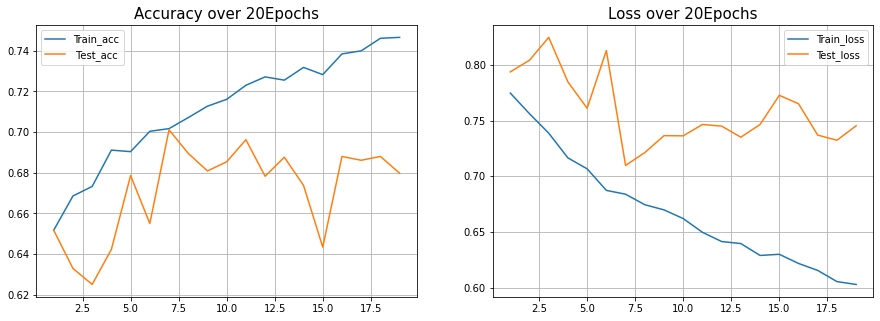

In [ ]:
# Avaliação
import matplotlib.pyplot as plt

def plot_acc_loss(result, epochs):
    acc = result.history['acc']
    loss = result.history['loss']
    val_acc = result.history['val_acc']
    val_loss = result.history['val_loss']
    plt.figure(figsize = (15, 5))
    plt.subplot(121)
    plt.plot(range(1, epochs), acc[1:], label = 'Train_acc')
    plt.plot(range(1, epochs), val_acc[1:], label =' Test_acc')
    plt.title('Accuracy over ' + str(epochs) + 'Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1, epochs), loss[1:], label = 'Train_loss')
    plt.plot(range(1, epochs), val_loss[1:], label = 'Test_loss')
    plt.title('Loss over ' + str(epochs) + 'Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_acc_loss(result, 20)

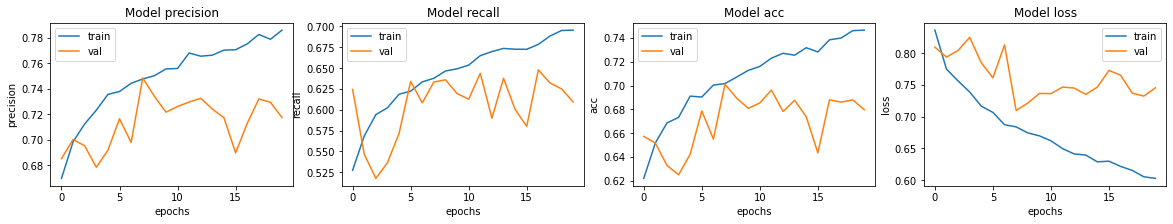

In [ ]:
# Verificando as Métricas

fig, ax = plt.subplots(1, 4, figsize = (20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "acc", "loss"]):
    ax[i].plot(result.history[met])
    ax[i].plot(result.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

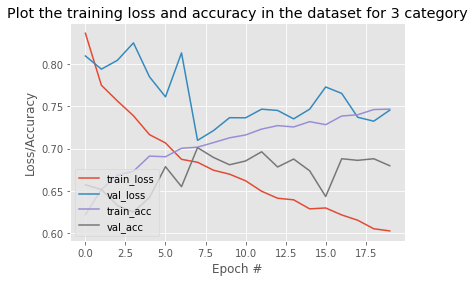

In [ ]:
# Plot the training loss and accuracy
N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), result.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), result.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), result.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), result.history["val_acc"], label="val_acc")
plt.title("Plot the training loss and accuracy in the dataset for 3 category")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
# Salve o modelo
model.save('Covid_Multiclass3.h5')

In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(
        test_dir,target_size = IMAGE_SIZE,
        batch_size = 1,
        shuffle = True,
        seed = 42,
        class_mode = "categorical")
eval_generator.reset()

x = model.evaluate_generator(eval_generator,
                           steps = np.ceil(len(eval_generator) / BATCH_SIZE),
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1)

print('Test loss:' , x[0])
print('Test accuracy:', x[1])

Found 3345 images belonging to 3 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.
335/335 [==============================] - 3s 8ms/step - loss: 0.8464 - acc: 0.6328 - precision: 0.6701 - recall: 0.5761
Test loss: 0.8463748693466187
Test accuracy: 0.6328358054161072


In [ ]:
# Prever 1
eval_generator.reset()  
pred = model.predict_generator(eval_generator, 1000, verbose = 1)
print("Previsões concluídas")

Instructions for updating:
Please use Model.predict, which supports generators.
1000/1000 [==============================] - 7s 7ms/step
Previsões concluídas


In [ ]:
STEP_SIZE_TRAIN = train_batches.n//train_batches.batch_size
STEP_SIZE_VALID = valid_batches.n//valid_batches.batch_size

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr = 5e-5), # aprendizagem de 5E-5
              metrics = ['acc', tf.keras.metrics.Precision(name = "precision"), tf.keras.metrics.Recall(name = "recall")])

result = model.fit_generator(train_batches,
                        steps_per_epoch = STEP_SIZE_TRAIN,
                        validation_data = valid_batches,
                        validation_steps = STEP_SIZE_VALID,
                        epochs= 15)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


1070/1070 [==============================] - 96s 90ms/step - loss: 0.8616 - acc: 0.6038 - precision: 0.6639 - recall: 0.4885 - val_loss: 0.7832 - val_acc: 0.6640 - val_precision: 0.7176 - val_recall: 0.5768
Epoch 2/15
1070/1070 [==============================] - 96s 90ms/step - loss: 0.7721 - acc: 0.6604 - precision: 0.7097 - recall: 0.5730 - val_loss: 0.7688 - val_acc: 0.6599 - val_precision: 0.7108 - val_recall: 0.5625
Epoch 3/15
1070/1070 [==============================] - 96s 90ms/step - loss: 0.7566 - acc: 0.6693 - precision: 0.7109 - recall: 0.5909 - val_loss: 0.7707 - val_acc: 0.6794 - val_precision: 0.7257 - val_recall: 0.5996
Epoch 4/15
1070/1070 [==============================] - 98s 92ms/step - loss: 0.7460 - acc: 0.6790 - precision: 0.7267 - recall: 0.6077 - val_loss: 0.7343 - val_acc: 0.6884 - val_precision: 0.7296 - val_recall: 0.5993
Epoch 5/15
1070/1070 [==============================] - 98s 91ms/step - loss: 0.7277 - acc: 0.6836 - precision: 0.7259 - recall: 0.6081 - v

In [ ]:
eval_generator.reset()  
x = model.evaluate_generator(eval_generator,
                           steps = np.ceil(len(eval_generator) / BATCH_SIZE),
                           use_multiprocessing = False,
                           verbose = 1,
                           workers = 1)

print('Test loss:', x[0])
print('Test accuracy:', x[1])

335/335 [==============================] - 3s 9ms/step - loss: 0.8218 - acc: 0.6418 - precision: 0.6849 - recall: 0.5970
Test loss: 0.8217940330505371
Test accuracy: 0.641791045665741


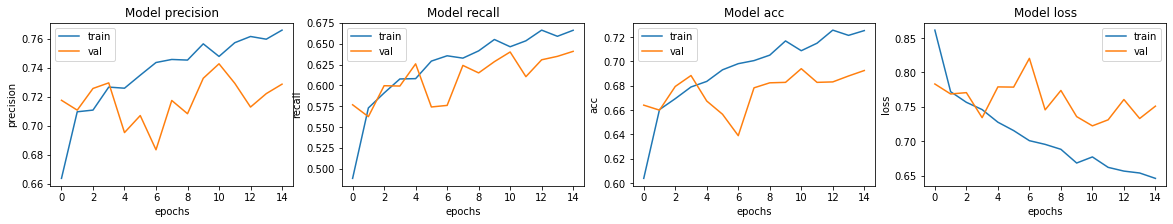

In [ ]:
# Verificando as Métricas
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 4, figsize = (20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "acc", "loss"]):
    ax[i].plot(result.history[met])
    ax[i].plot(result.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

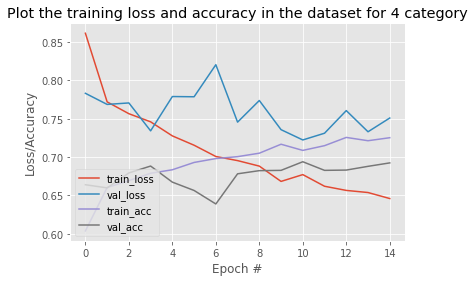

In [ ]:
# Plot the training loss and accuracy
N = 15
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), result.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), result.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), result.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), result.history["val_acc"], label="val_acc")
plt.title("Plot the training loss and accuracy in the dataset for 4 category")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(
        test_dir,target_size=IMAGE_SIZE,
        batch_size = 1,
        shuffle = True,
        seed = 42,
        class_mode = "categorical")
eval_generator.reset()

x = model.evaluate_generator(eval_generator,
                           steps = np.ceil(len(eval_generator) / BATCH_SIZE),
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1)

print('Test loss:' , x[0])
print('Test accuracy:', x[1])

Found 3345 images belonging to 3 classes.
335/335 [==============================] - 3s 9ms/step - loss: 0.8464 - acc: 0.6328 - precision: 0.6701 - recall: 0.5761
Test loss: 0.8463748693466187
Test accuracy: 0.6328358054161072


### Classificação de Pornography Binário

*   Porn
*   NonPorn (Fácil)



In [ ]:
# Exclua algumas classes que podem interferir
!rm -rf /content/Frames/all/train/NonPornDifficulty

In [ ]:
from os import listdir
data_list = listdir('/content/Frames/all/train')

data_list

['NonPorn', 'Porn']

In [ ]:
# Parametros de treinamento
DATASET_PATH  = '/content/Frames/all/train'
test_dir =  '/content/Frames/all/test'
IMAGE_SIZE    = (150, 150)
NUM_CLASSES   = len(data_list)
BATCH_SIZE    = 10  
NUM_EPOCHS    = 10
LEARNING_RATE = 0.0005 

In [ ]:
# Treinar dados pré-processador
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 50,
                                   featurewise_center = True,
                                   featurewise_std_normalization = True,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.25,
                                   zoom_range = 0.1,
                                   zca_whitening = True,
                                   channel_shift_range = 20,
                                   horizontal_flip = True ,
                                   vertical_flip = True ,
                                   validation_split = 0.2,
                                   fill_mode = 'constant')

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:
train_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size = IMAGE_SIZE,
                                                  shuffle = True,
                                                  batch_size = BATCH_SIZE,
                                                  subset = "training",
                                                  seed = 42,
                                                  class_mode = "binary")

Found 8431 images belonging to 2 classes.


In [ ]:
valid_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size = IMAGE_SIZE,
                                                  shuffle = True,
                                                  batch_size = BATCH_SIZE,
                                                  subset = "validation",
                                                  seed = 42,
                                                  class_mode = "binary")

Found 2107 images belonging to 2 classes.


In [ ]:
# Modificação de camada na camada superior de VGG16
# Modelo simples de CNN baseado em VGG16

from keras import models
from keras import layers
from keras.applications import VGG16
from keras import optimizers
from keras.layers.core import Flatten, Dense, Dropout, Lambda

conv_base = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape = (150, 150, 3))

conv_base.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss ='binary_crossentropy',
              optimizer = optimizers.Adam(lr = LEARNING_RATE),
              metrics = ['acc', tf.keras.metrics.Precision(name = "precision"), tf.keras.metrics.Recall(name = "recall")])

In [ ]:
# Sumário do Modelo
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [ ]:
# Treinamento
# MODELO FIT
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN = train_batches.n//train_batches.batch_size
STEP_SIZE_VALID = valid_batches.n//valid_batches.batch_size

result = model.fit_generator(train_batches,
                        steps_per_epoch = STEP_SIZE_TRAIN,
                        validation_data = valid_batches,
                        validation_steps = STEP_SIZE_VALID,
                        epochs = 15)

844
211
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


843/843 [==============================] - 79s 93ms/step - loss: 0.5234 - acc: 0.7435 - precision: 0.7375 - recall: 0.7310 - val_loss: 0.4202 - val_acc: 0.8100 - val_precision: 0.8911 - val_recall: 0.6922
Epoch 2/15
843/843 [==============================] - 78s 93ms/step - loss: 0.4506 - acc: 0.7884 - precision: 0.7855 - recall: 0.7755 - val_loss: 0.4058 - val_acc: 0.8114 - val_precision: 0.8830 - val_recall: 0.7043
Epoch 3/15
843/843 [==============================] - 78s 93ms/step - loss: 0.4353 - acc: 0.7978 - precision: 0.7945 - recall: 0.7865 - val_loss: 0.3710 - val_acc: 0.8319 - val_precision: 0.8042 - val_recall: 0.8621
Epoch 4/15
843/843 [==============================] - 78s 93ms/step - loss: 0.4170 - acc: 0.8074 - precision: 0.8021 - recall: 0.8005 - val_loss: 0.3953 - val_acc: 0.8152 - val_precision: 0.7725 - val_recall: 0.8772
Epoch 5/15
843/843 [==============================] - 78s 93ms/step - loss: 0.4122 - acc: 0.8079 - precision: 0.8086 - recall: 0.7908 - val_loss: 0

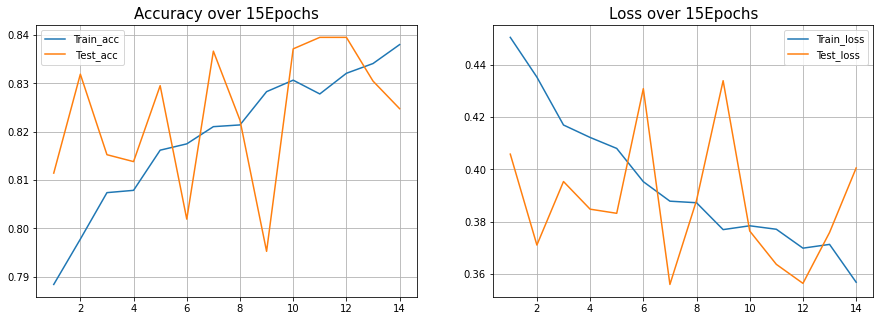

In [ ]:
# Avaliação
import matplotlib.pyplot as plt

def plot_acc_loss(result, epochs):
    acc = result.history['acc']
    loss = result.history['loss']
    val_acc = result.history['val_acc']
    val_loss = result.history['val_loss']
    plt.figure(figsize = (15, 5))
    plt.subplot(121)
    plt.plot(range(1, epochs), acc[1:], label = 'Train_acc')
    plt.plot(range(1, epochs), val_acc[1:], label =' Test_acc')
    plt.title('Accuracy over ' + str(epochs) + 'Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1, epochs), loss[1:], label = 'Train_loss')
    plt.plot(range(1, epochs), val_loss[1:], label = 'Test_loss')
    plt.title('Loss over ' + str(epochs) + 'Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_acc_loss(result, 15)

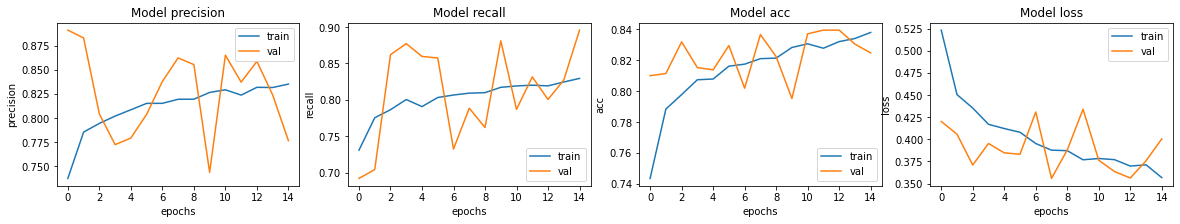

In [ ]:
# Verificando as Métricas

fig, ax = plt.subplots(1, 4, figsize = (20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "acc", "loss"]):
    ax[i].plot(result.history[met])
    ax[i].plot(result.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

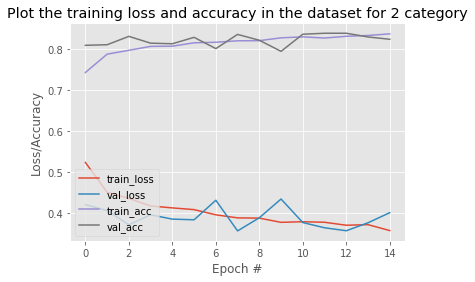

In [ ]:
# Plot the training loss and accuracy
N = 15
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), result.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), result.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), result.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), result.history["val_acc"], label="val_acc")
plt.title("Plot the training loss and accuracy in the dataset for 2 category")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
# Salve o modelo
model.save('Covid_Binary4.h5')

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1. / 255)
eval_generator = test_datagen.flow_from_directory(
 test_dir,target_size = IMAGE_SIZE,
 batch_size = 1,
 shuffle = False,
 seed = 42,
 class_mode = "binary")

eval_generator.reset()
x = model.evaluate_generator(eval_generator,
 steps = np.ceil(len(eval_generator) / BATCH_SIZE),
 use_multiprocessing = False,
 verbose = 1,
 workers=1)

print("Test loss:" , x[0])
print("Test accuracy:",x[1])

Found 3345 images belonging to 3 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.
335/335 [==============================] - 3s 8ms/step - loss: 0.5869 - acc: 0.6985 - precision: 0.0000e+00 - recall: 0.0000e+00
Test loss: 0.5869496464729309
Test accuracy: 0.6985074877738953


In [ ]:
# Prever
eval_generator.reset()  
pred = model.predict_generator(eval_generator,1000,verbose=1)
print("Previsões concluídas")

Instructions for updating:
Please use Model.predict, which supports generators.
1000/1000 [==============================] - 7s 7ms/step
Previsões concluídas


### Referências

https://danielmoreira.github.io/publication/2016_fsi/paper.pdf

https://www.researchgate.net/publication/318408211_Adult_Content_Detection_in_Videos_with_Convolutional_and_Recurrent_Neural_Networks

https://www.sciencedirect.com/science/article/abs/pii/S0925231217312493?via%3Dihub#!

https://www.oreilly.com/library/view/python-data-science/9781491912126/ch04.html

https://github.com/bakwc/PornDetector/blob/master/nnpcr.py

https://sites.google.com/site/pornographydatabase/

https://drive.google.com/file/d/0B3VWBzmbuQ5tOHJHeGNMbXhseHc/view

https://recodbr.wordpress.com/code-n-data/#porno

https://github.com/yahoo/open_nsfw

http://gvis.unileon.es/wp-content/uploads/2018/09/PAPERID_82_ICDP2017_Camera_Ready_Pornography-and-Child-Sexual-Abuse-Detection-in-Image-and-Video.pdf